<a href="https://colab.research.google.com/github/kburns/cism_dedalus_2023/blob/main/lecture_4_shallow_water_evp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigenvalue Problems -- Shallow Water on the Sphere

**Overview:** This notebook describes how to solve an eigenvalue problem to find the fastest growing mode in a shear flow on the sphere, and initialize a simulation with that mode.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

# Setup

This cell checks if Dedalus is installed and performs some other basic setup.

If Dedalus is not installed and you are using Google Colab, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details -- just execute the cell.

If you are not using Google Colab, follow the installation instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.
Installation using conda is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm Dedalus is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


# Content

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
%matplotlib widget

Let's consider the shallow water equations on the sphere, with $u$ being the horizontal fluid velocity, and the total fluid depth being $H + h$ for constant $H$.

$$\partial_t u + u \cdot \nabla u = - g \nabla h - 2 \Omega \times u -\nu \nabla^4 u$$
$$\partial_t h + \nabla \cdot ((H + h) u) = -\nu \nabla^4 h$$

Here we've adding a regularizing hyperviscosity to both equations.
[Gelewsky et al. (2004)](https://doi.org/10.3402/tellusa.v56i5.14436) is a classic test problem for spherical shallow-water solvers which examines the evolution of a balanced, barotropically unstable, mid-latitude jet under a prescribed perturbation.
Here we'll go a bit farther and find and evolve the most unstable mode of the jet using the eigenvalue problem in Dedalus. 

This will give us three problems in total:
* An LBVP to find the height field balancing the prescribed jet profile.
* An EVP to find the most unstable mode of the jet.
* An IVP to examine the nonlinear evolution of the instability.

## 1. Setup domain

First let's set some basic parameters and build the domain.

In [3]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600

# Parameters
Nphi = 256
Ntheta = 128
dealias = (3/2, 3/2)
R = 6.37122e6 * meter
Omega = 7.292e-5 / second
g = 9.80616 * meter / second**2
H = 1e4 * meter
dtype = np.float64

Now let's build two bases for the sphere. First, one to just represent zonally constant fields, and second, one to represent full 2D fields on the sphere:

In [4]:
# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

## 2. Balanced zonal jet (LBVP)

We start with prescribing a mid-latitude zonal jet, and solving a zonally-symmetric LBVP to find the height field that balances this jet profile.
This will be the background state of our eigenvalue problem.

First we build the background fields using the zonally symmetric basis:

In [5]:
# Backgroudn fields
u0 = dist.VectorField(coords, name='u', bases=zonal_basis)
h0 = dist.Field(name='h', bases=zonal_basis)

Next let's setup the zonal jet (the details here are from the reference above):

In [6]:
# Setup zonal jet
phi, theta = dist.local_grids(zonal_basis)
lat = np.pi / 2 - theta + 0*phi
umax = 80 * meter / second
lat0 = np.pi / 7
lat1 = np.pi / 2 - lat0
en = np.exp(-4 / (lat1 - lat0)**2)
jet = (lat0 <= lat) * (lat <= lat1)
u_jet = umax / en * np.exp(1 / (lat[jet] - lat0) / (lat[jet] - lat1))
u0['g'][0][jet]  = u_jet

We can now solve for the balancing height field (ignoring hyperdiffusivity).
This comes from taking the divergence of the momentum equation, and using a gauge freedom to fix the mean of $h$ to be 0:

In [7]:
# Substitutions
zcross = lambda A: d3.MulCosine(d3.skew(A))

# Find balanced height field
c = dist.Field(name='c')
problem = d3.LBVP([h0, c], namespace=locals())
problem.add_equation("g*lap(h0) + c = - div(u0@grad(u0) + 2*Omega*zcross(u0))")
problem.add_equation("ave(h0) = 0")
solver = problem.build_solver()
solver.solve()

2024-09-27 10:17:56,462 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s


Let's plot these backgrounds:

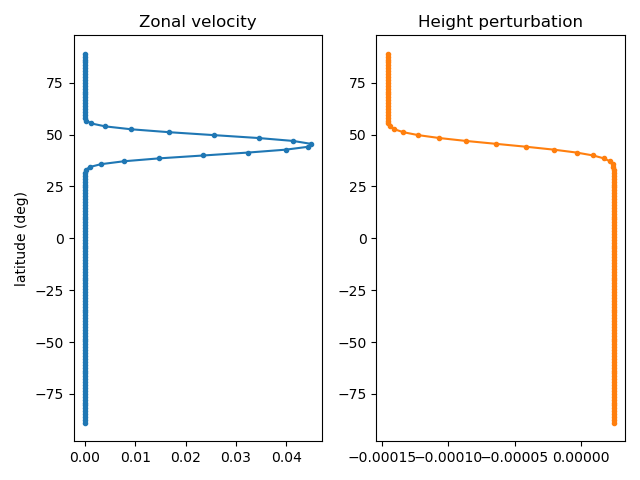

In [8]:
u0.change_scales(1)
h0.change_scales(1)

fig, ax = plt.subplots(1,2)
ax[0].plot(u0['g'][0][0], lat[0]*180/np.pi, '.-', color='C0')
ax[0].set_title('Zonal velocity')
ax[0].set_ylabel('latitude (deg)')
ax[1].plot(h0['g'][0], lat[0]*180/np.pi, '.-', color='C1', label='height')
ax[1].set_title('Height perturbation')
plt.tight_layout()

## 3. Finding the most unstable mode (EVP)

Instead of prescribing some simple pertubation, we can use Dedalus to solve eigenvalue problems to find the most unstable linear eigenmode of the balanced jet.
To do this, we create new fields representing perturbations to the jet and the eigenvalue, and build an EVP for linearized the equations around the background state.

We need to pass the eigenvalue field $\sigma$ to the `EVP` class on instantiation, and can use it multiplicatively in the equations.

In [9]:
# Perturbation fields
u1 = dist.VectorField(coords, name='u1', bases=full_basis)
h1 = dist.Field(name='h1', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u1, h1], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u1 + u1@grad(u0) + u0@grad(u1) + nu*lap(lap(u1)) + g*grad(h1) + 2*Omega*zcross(u1) = 0")
problem.add_equation("sigma*h1 + div(h0*u1) + div(h1*u0) + nu*lap(lap(h1)) + H*div(u1) = 0");

The eigenvalue solver (like all solvers in Dedalus) splits up the problem into its *linearly separable subproblems*.
Each of these *subproblems* is represented by a separate matrix -- these are the things constructed when you build a solver object, and together these form the diagonal blocks of the total linear system.
Here we have NCCs (the background flow) that depend on the latitude, meaning the system is linearly coupled over all $\ell$ for each $m$.

In any event, the eigenvalue solver allows you to find the eigenvalues for each subproblem independently.
The subproblems are objects in the `solver.subproblems` list.
Each has a `.group` attribute that describes the corresponding mode (wavenumber or spherical harmonic order/degree).
You can use the `solver.subproblems_by_group` dictionary to find the object associated with a given horizontal mode, here in the form `(m, None)` to indicate the matrices that couple all $\ell$ for a given $m$.

Here lets loop over the subproblems and compute the fastest growing mode for the first 15 spherical harmonic orders.

In [10]:
# Eigenvalue solver
m_max = 15
growth_rate = np.zeros(m_max + 1)
solver = problem.build_solver()
for m in range(m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/Users/kburns/Software/miniforge3/envs/d3/lib/python3.11/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2024-09-27 10:17:59,429 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.4e-01/s
2024-09-27 10:18:03,268 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s
2024-09-27 10:18:06,936 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.3e-01/s
2024-09-27 10:18:10,634 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.2e-01/s
2024-09-27 10:18:14,256 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.0e-01/s
2024-09-27 10:18:17,957 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.9e-01/s
2024-09-27 10:18:21,557 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 6.2e-01/s
2024-09-27 10:18:25,295 subsystems 0/1 INFO :: Building subproblem matrices 

Now let's plot the growth rates:

Text(0, 0.5, 'growth rate')

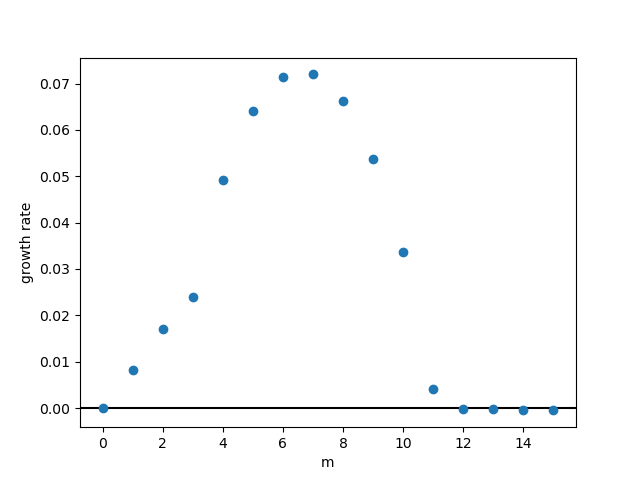

In [11]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')

We see that the jet is unstable to a range of low-m perturbations, but it's most unstable for $m=7$.
We can solve again for that subproblem and set the perturbation variables to the most unstable mode using the `solver.set_state` method:

In [12]:
sp = solver.subproblems_by_group[(7, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

/Users/kburns/Dropbox/Git/dedalus3master/dedalus/tools/array.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  dest[:] = src


Now we can plot e.g. the height perturbation in the eigenmode:

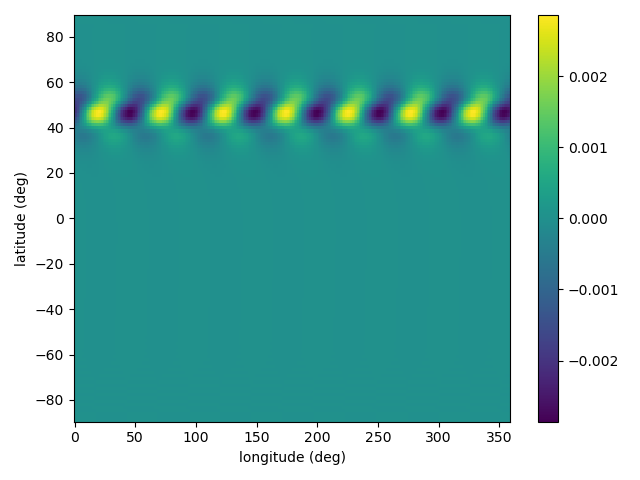

In [13]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h1['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()

## 4. Evolving the most unstable mode (IVP)

Now we can run an nonlinear IVP, starting with the background jet plus a small amount of the most unstable mode, to see how it saturates.
First we make new fields for the total variables and set their initial conditions using the background and fasting growing mode.

In [14]:
# Full fields
u = dist.VectorField(coords, name='u', bases=full_basis)
h = dist.Field(name='h', bases=full_basis)
u0.change_scales(1)
u1.change_scales(1)
h0.change_scales(1)
h1.change_scales(1)
u['g'] = u0['g'] + 1e-3*u1['g']
h['g'] = h0['g'] + 1e-3*h1['g']

Now we can run the full forward simulation using our original nonlinear equation set:

In [15]:
# Timestepping parameters
timestep = 600 * second
stop_sim_time = 240 * hour

# Problem
problem = d3.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + nu*lap(lap(h)) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour)
snapshots.add_task(h, name='height')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 100 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-09-27 10:19:06,357 subsystems 0/1 INFO :: Building subproblem matrices 1/127 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 3.9e+01/s
2024-09-27 10:19:06,521 subsystems 0/1 INFO :: Building subproblem matrices 13/127 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 6.9e+01/s
2024-09-27 10:19:06,693 subsystems 0/1 INFO :: Building subproblem matrices 26/127 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 7.2e+01/s
2024-09-27 10:19:06,878 subsystems 0/1 INFO :: Building subproblem matrices 39/127 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 7.1e+01/s
2024-09-27 10:19:07,081 subsystems 0/1 INFO :: Building subproblem matrices 52/127 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 6.9e+01/s
2024-09-27 10:19:07,281 subsystems 0/1 INFO :: Building subproblem matrices 65/127 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 6.8e+01/s
2024-09-27 10:19:07,480 subsystems 0/1 INFO :: Building subproblem matrices 78/127 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 6.8e+01/s
2024-09-27 10:19:07,678 subsystems 0/1 INFO :: Building subprobl

Finally, let's make a movie of the solution using some plotting tools from another script:

In [16]:
import matplotlib
from matplotlib import animation
from IPython.display import HTML
import h5py

# Plot parameters
task = 'vorticity'
cmap = plt.cm.RdBu_r
dpi = 100
figsize = (6, 6)

def build_s2_coord_vertices(phi, theta):
    phi = phi.ravel()
    phi_vert = np.concatenate([phi, [2*np.pi]])
    phi_vert -= phi_vert[1] / 2
    theta = theta.ravel()
    theta_mid = (theta[:-1] + theta[1:]) / 2
    theta_vert = np.concatenate([[np.pi], theta_mid, [0]])
    return np.meshgrid(phi_vert, theta_vert, indexing='ij')

# Create figure
with h5py.File('snapshots/snapshots_s1.h5', mode='r') as file:
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # Plot writes
    dset = file['tasks'][task]
    phi = dset.dims[1][0][:].ravel()
    theta = dset.dims[2][0][:].ravel()
    phi_vert, theta_vert = build_s2_coord_vertices(phi, theta)
    x = np.sin(theta_vert) * np.cos(phi_vert)
    y = np.sin(theta_vert) * np.sin(phi_vert)
    z = np.cos(theta_vert)
    data = dset[0]
    clim = np.max(np.abs(dset[:]))
    norm = matplotlib.colors.Normalize(-clim, clim)
    fc = cmap(norm(data))
    surf = ax.plot_surface(x, y, z, facecolors=fc, cstride=1, rstride=1, linewidth=0, antialiased=False, shade=False, zorder=5)
    ax.set_box_aspect((1,1,1))
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    ax.axis('off')

    def animate(i):
        data = dset[i]
        fc = cmap(norm(data))
        surf.set_facecolors(fc.reshape(fc.size//4, 4))
        return surf

    anim = animation.FuncAnimation(fig, animate, frames=dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2024-09-27 10:21:44,506 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-09-27 10:21:44,508 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/gl/8q1_pm2s1490lvyfvm_8yby80000gn/T/tmp8tzvqhz0/temp.m4v
